# This notebook will show how to use the ROSE framework to run an Active Learning workflow

In [1]:
import os
import sys

from rose.learner import SequentialActiveLearner
from rose.engine import Task, ResourceEngine
from rose.metrics import MEAN_SQUARED_ERROR_MSE

### Let us first declare the resource engine for our active learning tasks.
We will ask for 30 minutes, and the target resources will be local, which means it will run on the user's machine.

Next, we define the active learner and assign the resource engine.

In [2]:
engine = ResourceEngine({'runtime': 30,
                         'resource': 'local.localhost'})
acl = SequentialActiveLearner(engine)
code_path = f'{sys.executable} {os.getcwd()}'

Resource Engine started successfully



### Now, let us define our active learning tasks: simulation, training, and active learning

In [3]:
# Define and register the simulation task
@acl.simulation_task
def simulation(*args):
    return Task(executable=f'{code_path}/sim.py')

# Define and register the training task
@acl.training_task
def training(*args):
    return Task(executable=f'{code_path}/train.py')

# Define and register the active learning task
@acl.active_learn_task
def active_learn(*args):
    return Task(executable=f'{code_path}/active.py')

Optionally, we can define a stop criterion, which will be invoked on every iteration of the Active learning loop and break the iterations if it is satisfied.

In [4]:
# Defining the stop criterion with a metric (MSE in this case)
@acl.as_stop_criterion(metric_name=MEAN_SQUARED_ERROR_MSE, threshold=0.001)
def check_mse(*args):
    return Task(executable=f'{code_path}/check_mse.py')

<div class="alert alert-block alert-info"> <b>NOTE:</b> ROSE supports a variety of `METRICS`, which can be used to evaluate the model's performance. However, it also supports custom metrics that users can define when they specify the criterion function. </div>



<div class="alert alert-block alert-warning">  <b>WARNING:</b> For custom metrics, users must specify the `operator` field as below: </div>

```python
from rose.metrics import LESS_THAN_THRESHOLD
@acl.as_stop_criterion(metric_name='metric_x',
                       operator=LESS_THAN_THRESHOLD, threshold=0.001)
def check_metric_x(*args):
    return Task(executable=f'{code_path}/check_metric_x.py')
```

### Now let us invoke the tasks to build the active learning workflow

In [5]:
# Now, call the tasks and teach
simul = simulation()
train = training()
active = active_learn()
stop_cond = check_mse()

### Once the workflow is built, we can start the teaching process

In [6]:
# Start the teaching process
acl.teach(max_iter=10)

Registered task 'simulation' and id of 000000 with dependencies: []
Registered task 'training' and id of 000001 with dependencies: ['simulation']
Starting Iteration-0
Registered task 'active_learn' and id of 000002 with dependencies: ['simulation', 'training']
Registered task 'check_mse' and id of 000003 with dependencies: ['active_learn']
Registered task 'simulation' and id of 000004 with dependencies: ['active_learn']
Registered task 'training' and id of 000005 with dependencies: ['simulation']
Starting Iteration-1
Registered task 'active_learn' and id of 000006 with dependencies: ['simulation', 'training']
Registered task 'check_mse' and id of 000007 with dependencies: ['active_learn']
Registered task 'simulation' and id of 000008 with dependencies: ['active_learn']
Registered task 'training' and id of 000009 with dependencies: ['simulation']
Starting Iteration-2
Registered task 'active_learn' and id of 000010 with dependencies: ['simulation', 'training']
Registered task 'check_mse'

### Once the teaching process is finished, we will make sure to terminate the resources

In [7]:
# Start the teaching process
engine.shutdown()

Shutdown is triggered, terminating the resources gracefully


### To better understand our model performance, we will plot the MSE of each iteration.

Text(0.5, 1.0, 'MSE Values for Machine Learning Model')

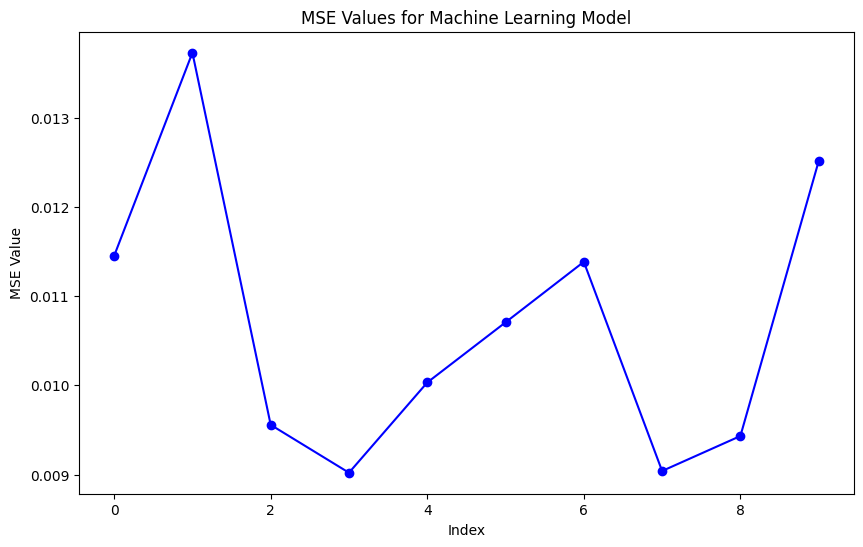

In [8]:
import matplotlib.pyplot as plt
# Convert string values to floats
mse_values = acl.get_result(task_name='check_mse')
mse_values = [float(mse.strip()) for mse in mse_values]

# Plot the MSE values
plt.figure(figsize=(10, 6))
plt.plot(mse_values, marker='o', color='b', linestyle='-', markersize=6)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('MSE Value')
plt.title('MSE Values for Machine Learning Model')